# Imports

## Python Libraries

In [93]:
import faiss
import numpy as np
import os
import pandas as pd
import pickle
import torch
import torch.nn.functional as F

from copy import deepcopy
from datetime import datetime
import json 
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader,Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, models



## Importing the datasets

In [94]:
dataset = pd.read_csv('Datasets/Products.csv', lineterminator='\n')

# Cleaning the Dataset

## Cleaning the table

In [95]:
dataset.count(), dataset.dropna().count(), dataset["price"].map(lambda x: x[0]).unique(), dataset["price"].map(lambda x: x[-3:]).unique()

(Unnamed: 0             7156
 id                     7156
 product_name           7156
 category               7156
 product_description    7156
 price                  7156
 location               7156
 dtype: int64,
 Unnamed: 0             7156
 id                     7156
 product_name           7156
 category               7156
 product_description    7156
 price                  7156
 location               7156
 dtype: int64,
 array(['£'], dtype=object),
 array(['.00', '.99', '.78', '.01', '.97', '.25', '.50', '.20', '.90',
        '.80', '.60', '.23', '.05', '.75', '.56', '.40', '.44', '.95',
        '.66', '.35', '.85', '.30', '.45', '.16', '.69', '.49', '.55',
        '.09', '.11'], dtype=object))

In [96]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7156 entries, 0 to 7155
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           7156 non-null   int64 
 1   id                   7156 non-null   object
 2   product_name         7156 non-null   object
 3   category             7156 non-null   object
 4   product_description  7156 non-null   object
 5   price                7156 non-null   object
 6   location             7156 non-null   object
dtypes: int64(1), object(6)
memory usage: 391.5+ KB


# So the dataset seems to already be clean

Now we convert the price column

In [97]:
dataset_cleaned = dataset

def remove_pound_sign(string_to_replace) -> str:
    return 

dataset_cleaned['price'] = dataset_cleaned['price'].map(lambda x : x.replace('£', '')) #Removes the pound signs
dataset_cleaned['price'] = dataset_cleaned['price'].map(lambda x: x.replace(',', '')) #Removes commas

dataset_cleaned['price'] = pd.to_numeric(dataset_cleaned['price'])

# Now we extract the root category from each item

In [98]:
dataset_cleaned['category'] = dataset_cleaned['category'].map(lambda x: x.split(' /' )[0])

In [99]:
dataset_cleaned['category'].unique()

array(['Home & Garden', 'Baby & Kids Stuff', 'DIY Tools & Materials',
       'Music, Films, Books & Games', 'Phones, Mobile Phones & Telecoms',
       'Clothes, Footwear & Accessories', 'Other Goods',
       'Health & Beauty', 'Sports, Leisure & Travel', 'Appliances',
       'Computers & Software', 'Office Furniture & Equipment',
       'Video Games & Consoles'], dtype=object)

Now we create an encoder to go to and from the categories and integers

In [100]:
list_of_categories = list(dataset_cleaned['category'].unique())

encoder = {x: list_of_categories.index(x) for x in list_of_categories}

decoder = {list_of_categories.index(x):x for x in list_of_categories}

encoder, decoder

#Let's save these to pickle files:

with open("encoder_pickle", 'wb') as encody:
    pickle.dump(encoder, encody)

with open("decoder_pickle", 'wb') as decody:
    pickle.dump(decoder, decody)

# Now we merge this with the original table:

In [101]:
dataset_cleaned['root_category'] = dataset_cleaned['category']
dataset_cleaned['root_category_index'] = dataset_cleaned['category'].map(lambda x:encoder[x])

# Next we merge this with the images table:

In [102]:
images_dataset = pd.read_csv('Datasets/Images.csv')

dataset_cleaned["merge_column"] = dataset_cleaned['id']
images_dataset['merge_column'] = images_dataset['product_id']

dataset_cleaned.dtypes, images_dataset.dtypes

(Unnamed: 0               int64
 id                      object
 product_name            object
 category                object
 product_description     object
 price                  float64
 location                object
 root_category           object
 root_category_index      int64
 merge_column            object
 dtype: object,
 Unnamed: 0       int64
 id              object
 product_id      object
 merge_column    object
 dtype: object)

In [103]:
merged_df = images_dataset.merge(dataset_cleaned, on='merge_column')

In [104]:
merged_df = merged_df[["id_x", "product_id", "root_category", "root_category_index"]]
merged_df = merged_df.rename(columns={'id_x':'id'})
merged_df = merged_df.drop(columns=['product_id'])

merged_df.dtypes

id                     object
root_category          object
root_category_index     int64
dtype: object

In [105]:
merged_df.to_csv('Datasets/training_data.csv', index=False)

## Clean Image Dataset:

In [106]:
def resize_image(final_size, im):
    size = im.size
    ratio = float(final_size) / max(size)
    new_image_size = tuple([int(x*ratio) for x in size])
    im = im.resize(new_image_size)
    new_im = Image.new("RGB", (final_size, final_size))
    new_im.paste(im, ((final_size-new_image_size[0])//2, (final_size-new_image_size[1])//2))
    return new_im

def clean_images(path_to_extract = "Datasets/images/", path_to_save = "Datasets/cleaned_images/", image_size = 64):
    dirs = os.listdir(path_to_extract)
    final_size = image_size
    for n, item in enumerate(dirs, 1):
        #print(n, item)
        im = Image.open(path_to_extract + item)
        #print(im.width, im.height)
        new_im = resize_image(final_size, im)
        #print(new_im.width, new_im.height)
        new_im.save(path_to_save + item)


In [107]:
#clean_images(path_to_save="Datasets/cleaned_images_64/")

# Working with the Model

## Casting into a PyTorch dataset

In [113]:
class ImageDataset(Dataset):
    def __init__(self, df_of_keys:pd.DataFrame, folder_of_images:str) -> None:
        super().__init__()

        # Set the labels to be the column 'root_cotegory_index' of df_of_keys
        self.labels = df_of_keys['root_category_index']

        # Assings image_paths to the file name from the column 'id' of df_of_keys and maps it to it's path relative to the project root folder
        self.image_paths = df_of_keys['id'].map(lambda x : folder_of_images + x + '.jpg')

        # The Resent50 documentation said these transforms must be applied to the images before the model processes them
        self.image_transformer = transforms.Compose([
            transforms.PILToTensor(),
            #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def __getitem__(self, index):
        
        # Opens the image at index with using PIL.Image
        with Image.open(self.image_paths[index]) as img:

            # Sets the feature to be a tensor obtained by applying PILToTensor to the relevant image
            X = self.image_transformer(img)
        
        # y is the label from self.labels
        y = self.labels[index]

        #print(X.shape, y.shape)
        return X, y
    
    def __len__(self):
        return len(self.labels)



In [114]:
my_dataset = ImageDataset(merged_df, "Datasets/cleaned_images_224/")

# A quick sanity check of the dataset:
my_dataset[1][0], my_dataset[1][1].shape, len(my_dataset)

(tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
 (),
 12604)

In [130]:
# Split merged_df to a train_df and validation_df
train_df, validation_df = train_test_split(merged_df, train_size=10000, test_size= len(merged_df) - 10000)

train_df.reset_index(inplace=True)
validation_df.reset_index(inplace=True)

# Create instances of the ImageDataset class
train_dataset = ImageDataset(train_df, "Datasets/cleaned_images_224/")
validation_dataset = ImageDataset(validation_df, "Datasets/cleaned_images_224/")

# Allow random flips and rotations when loading an image in the train dataset
train_dataset.image_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.PILToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Pass both to dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_dataset, batch_size=128, shuffle=True, drop_last=True)


## Splitting the dataset:

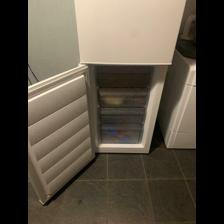

In [133]:
pillow_to_image = transforms.ToPILImage()

pillow_to_image(validation_dataset[712][0].squeeze(0))

## Defining the model

In [134]:
# Sets the device for PyTorch
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# Loads the resnet50 model
#resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', model = 'nvidia_resnet50', pretrained = True )
resnet50 = models.resnet50(weights='IMAGENET1K_V1')
# Don't know what this does
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')
# Again don't know what this does
resnet50.eval().to(device)

Using cache found in /home/ibs/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Examining the model

Let's print out the layers of resnet50, and if they're differentiable:

In [135]:
def show_model_layers(model):
    for name, module in model.named_parameters():
        if module.requires_grad:
            print('Here!', name, module.requires_grad)
        else:
            print(name, module.requires_grad)

In [136]:
show_model_layers(resnet50)

Here! conv1.weight True
Here! bn1.weight True
Here! bn1.bias True
Here! layer1.0.conv1.weight True
Here! layer1.0.bn1.weight True
Here! layer1.0.bn1.bias True
Here! layer1.0.conv2.weight True
Here! layer1.0.bn2.weight True
Here! layer1.0.bn2.bias True
Here! layer1.0.conv3.weight True
Here! layer1.0.bn3.weight True
Here! layer1.0.bn3.bias True
Here! layer1.0.downsample.0.weight True
Here! layer1.0.downsample.1.weight True
Here! layer1.0.downsample.1.bias True
Here! layer1.1.conv1.weight True
Here! layer1.1.bn1.weight True
Here! layer1.1.bn1.bias True
Here! layer1.1.conv2.weight True
Here! layer1.1.bn2.weight True
Here! layer1.1.bn2.bias True
Here! layer1.1.conv3.weight True
Here! layer1.1.bn3.weight True
Here! layer1.1.bn3.bias True
Here! layer1.2.conv1.weight True
Here! layer1.2.bn1.weight True
Here! layer1.2.bn1.bias True
Here! layer1.2.conv2.weight True
Here! layer1.2.bn2.weight True
Here! layer1.2.bn2.bias True
Here! layer1.2.conv3.weight True
Here! layer1.2.bn3.weight True
Here! la

- The final layer, `fc` takes in 2048 features and outputs 1000 features. The number of labels we need to classify, i.e. the number of distinct values in `merged_df['root_categories']` is 13.

- So we need to modify the `fc` layer so that it has 13 outputs. We do this by changing `fc` to `torch.nn.Linear(2048, 13)`.

In [153]:
class ImageClassifier(torch.nn.Module):
    def __init__(self, num_labels:int) -> None:
        super().__init__()
        self.resnet50 = models.resnet50(weights='IMAGENET1K_V1')
        
        # Freeze all the layers, by setting 'requires_grad = False'
        for param in self.resnet50.parameters():
            param.requires_grad = False

        # Unfreeze the final layer of renset50:

        for param in self.resnet50.fc.parameters():
            param.requires_grad = True
        
        # Add a linear layer reducing the 1000 label output to num_labels
        
        self.final = torch.nn.Sequential(
            torch.nn.ReLU(),
            torch.nn.Linear(1000, num_labels),
            torch.nn.Softmax(dim=1),
        )

    def forward(self, X):
        X = X.float()
        X = self.resnet50(X)
        X = self.final(X)
        return X
    
    @torch.no_grad()
    def forward_no_grad(self, X):
        X = X.float()
        X = self.resnet50(X)
        X = self.final(X)
        return X

In [154]:
model = ImageClassifier(13)
model.cuda()

#show_model_layers(model)

#accuracy_score_from_valiadation(model, validation_loader)

ImageClassifier(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
 

In [155]:
# The training loop. Takes in a model, the training and validation data loaders, the number of epochs and the initial learning rate
def train(model, train_loader, validation_loader, epochs = 10, learning_rate = 1):
    torch.cuda.memory_summary(device=device, abbreviated=False)

    torch.cuda.empty_cache()

    # Set the optimiser to be an instance of the stochastic gradient descent class
    # Only want the parameters in fc to be updated
    optimiser = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Define a learning rate scheduler as an instance of the ReduceLROnPlateau class
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', patience=50, cooldown=7, eps=1e-20)

    # Writer will be used to track model performance with TensorBoard
    writer = SummaryWriter()

    # Keep track of the number of batches to plot model performace against
    batch_index = 0
    
    # Prints an validation score
    print(f"Initial validation accuracy score{accuracy_score_from_valiadation(model, validation_loader)}")

    #Create a dictionary to store the best model parameters
    best_model_parameters = {'Epoch':-1, 'Accuracy':0, 'Parameters':model.state_dict()}

    # Loop over the number of epochs
    for epoch in range(epochs):

        # Within each epoch, we pass through the entire training data in batches indexed by batch
        for batch in train_loader:
            # Loads features and labels into device for performance improvements
            features, labels = batch

            features = features.to(device)
            labels = labels.to(device)

            # Calculate the loss via cross_entropy
            loss = F.cross_entropy(model(features), labels)

            # Create the grad attributes
            loss.backward() 

            # Print the performance
            print(f"Epoch: {epoch}, batch index: {batch_index}, learning rate: {scheduler.get_last_lr()}, loss:{loss.item()}")

            # Perform one step of stochastic gradient descent
            optimiser.step()

            # Zero the gradients (Apparently set_to_none=True imporves performace)
            optimiser.zero_grad(set_to_none=True)

            # Feed the loss amount into the learning rate scheduler to decide the next learning rate
            scheduler.step(loss.item())

            # Write the performance to the TensorBoard plot
            writer.add_scalar('loss', loss.item(), batch_index)

            # Increment the batch index
            batch_index += 1
        
        # Print the validation loss
        print('Calculating validation accuracy')
        accuracy = accuracy_score_from_valiadation(model, validation_loader)
        print(f"Epoch {epoch}, validation accuracy score{accuracy}")

        # Check if the model has the best perfomrance and save the parameters to 'best_model.pt'
        if accuracy > best_model_parameters['Accuracy']:
            best_model_parameters['Epoch'] = epoch
            best_model_parameters['Accuracy'] = loss.item()
            best_model_parameters['Parameters'] = model.state_dict()
            torch.save(model.state_dict(), 'model_evaluation/weights/best_model.pt')

        if epoch % 50 == 0:
            print(epoch % 50)
            # Create an instance of the datetime class
            dt = datetime.now()
            date_stamp = str(dt).replace(':', '_').replace('.', '_').replace(' ', '_')

            # Save the model parameters to the folder 'model_evaluation/weights', along with the time and epoch they were generated
            torch.save(model.state_dict(), f'model_evaluation/weights/model_{date_stamp}_epoch_{epoch}_accuracy_{accuracy}.pt') # Is there a better way to do this?
    
    print('Loading best model')
    
    #Update model parameters with the best model parameters:
    model.load_state_dict(best_model_parameters['Parameters'])
    print(f'The best model has validation accuracy {accuracy_score_from_valiadation(model, validation_loader)}')

def accuracy_score_from_valiadation(model, validation_loader):
    
    list_of_scores = []

    for batch in validation_loader:
        features, labels = batch

        features = features.to(device)
        labels = labels.to(device)

        predictions = torch.tensor([torch.argmax(prediction) for prediction in model(features)]).to(device)
        num_correct =  torch.sum(predictions == labels)

        list_of_scores.append(torch.div(num_correct, len(labels)).item())
    
    return sum(list_of_scores) / len(list_of_scores)



In [156]:
# Train the model
train(model, train_loader, validation_loader, epochs=20, learning_rate=1)

Initial validation accuracy score0.0671875
Epoch: 0, batch index: 0, learning rate: [1], loss:2.5718088150024414
Epoch: 0, batch index: 1, learning rate: [1], loss:2.524702310562134
Epoch: 0, batch index: 2, learning rate: [1], loss:2.6260454654693604
Epoch: 0, batch index: 3, learning rate: [1], loss:2.6024794578552246
Epoch: 0, batch index: 4, learning rate: [1], loss:2.610278606414795
Epoch: 0, batch index: 5, learning rate: [1], loss:2.5862069129943848
Epoch: 0, batch index: 6, learning rate: [1], loss:2.5980868339538574
Epoch: 0, batch index: 7, learning rate: [1], loss:2.520627975463867
Epoch: 0, batch index: 8, learning rate: [1], loss:2.5608558654785156
Epoch: 0, batch index: 9, learning rate: [1], loss:2.580871343612671
Epoch: 0, batch index: 10, learning rate: [1], loss:2.595214366912842
Epoch: 0, batch index: 11, learning rate: [1], loss:2.5403835773468018
Epoch: 0, batch index: 12, learning rate: [1], loss:2.5337564945220947
Epoch: 0, batch index: 13, learning rate: [1], lo

# Testing the image processing script

In [157]:
from image_processor import process_image

image_tensor = process_image("Datasets/images/ffff23f1-59fc-47bd-b0cd-186933803287.jpg").to(device)

model(image_tensor)

tensor([[0.1414, 0.0598, 0.0514, 0.0312, 0.0159, 0.0740, 0.0484, 0.0836, 0.1105,
         0.1903, 0.0741, 0.0781, 0.0411]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)

# Feature extraction model

In [185]:
class FeatureExtractionClass(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
    
        self.layers = torch.nn.Sequential(*list(model.children())[:-1])
    
    def forward(self, X):
        X = X.float()
        X = self.layers(X)
        return X

feature_extraction_model = FeatureExtractionClass()

feature_extraction_model.cuda()

torch.save(feature_extraction_model.state_dict(), 'model_evaluation/final_model/image_model.pt')

In [186]:
whole_data_loader = DataLoader(my_dataset,batch_size=1, shuffle=False)

In [189]:
batch = next(iter(whole_data_loader))

feature, label = batch

feature = feature.to(device)

feature_extraction_model(feature).shape

torch.Size([1, 1000])

In [198]:
def feature_extraction(json_file_name:str, folder_of_images:str, df_of_keys):
    transformer =  transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    dict_of_features = {}
    list_of_image_paths = df_of_keys['id'].map(lambda x : folder_of_images + x + '.jpg')

    for index in range(0, 100):#len(merged_df)):
        image_path = list_of_image_paths[index]
        with Image.open(image_path) as img:
            features = transformer(img).unsqueeze(0)
        features = features.to(device)
        image_embedding = feature_extraction_model(features)
        print(len(image_embedding))
        image_embedding = image_embedding.tolist()
        dict_of_features[df_of_keys['id'][index]] = image_embedding
    
    print(len(dict_of_features['912bb259-3ad9-457b-9db1-ce1da9016057'][0]))

    with open('my_dict.json', '+w') as file:
        json.dump(dict_of_features, file)
        

In [199]:
feature_extraction('123', 'Datasets/cleaned_images_224/', merged_df)

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1000


In [41]:
with open('my_dict.json', 'r') as file:
    new_dict = json.load(file)

new_dict['19dc00d3-7745-49de-8a55-b240a30de790']

[0.5468047261238098,
 0.13903814554214478,
 0.9730392694473267,
 0.9145287871360779,
 0.19091081619262695,
 0.10968810319900513,
 0.9493284225463867,
 0.12440842390060425,
 0.17989367246627808,
 0.2713906764984131,
 0.7974596619606018,
 0.5503571629524231,
 0.2194211483001709,
 0.15046101808547974,
 0.9386085867881775,
 0.685297429561615,
 0.8354539275169373,
 0.2687062621116638,
 0.09485846757888794,
 0.1985509991645813,
 0.8375774025917053,
 0.7260181903839111,
 0.016275525093078613,
 0.3562026619911194,
 0.9158496260643005,
 0.24581390619277954,
 0.33599936962127686,
 0.9377183318138123,
 0.8188729882240295,
 0.7700749635696411,
 0.5792426466941833,
 0.41430002450942993,
 0.29343175888061523,
 0.04645878076553345,
 0.292216420173645,
 0.6297909617424011,
 0.3563084006309509,
 0.9405226707458496,
 0.26415473222732544,
 0.8446291089057922,
 0.4981077313423157,
 0.6580413579940796,
 0.3168283700942993,
 0.42941492795944214,
 0.7891059517860413,
 0.1052054762840271,
 0.6722680926322937,